<a href="https://colab.research.google.com/github/Afav22-lab/Trabajo_clase_2162063/blob/main/super_resolution.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Single Image Super Resolution Problem**

The single image super resolution problem is a inverse problem where a low resolution image $\boldsymbol{y}$ is a decimated or corrupted version of a high resolution image $\boldsymbol{x}$. This can be expressed as a linear system as follows

$$
\boldsymbol{y} = \boldsymbol{h} \otimes \boldsymbol{x}
$$

where $\boldsymbol{h}$ is a decimation kernel with a spatial scale factor of $s$ and $\otimes$ denotes the convolution operator with a stride of $s$. A visual example of this problem is illustrated as follows


<img title="a title" alt="Alt text" width="800" src="https://assets-global.website-files.com/5d7b77b063a9066d83e1209c/62d919aa3b5e6e881507e2f8_image%20super%20resolution.jpg">


### **Objective**


To develop a deep learning model for the single image super-resolution (SISR) task.

### **Activities**

1. Improve the baseline performance of SISR employing state-of-the-art deep learning strategies.
3. Document the results, analysis and discussion of the selected strategy in
 a academic report.


### **Suggested Strategies**

These are suggested strategy but not limited, which can be adopted to improve the model performance

**Difficult Level:** $\star$


* Modify the learning rate parameter
* Modify the batch size parameter
* Modify Network Hyperparameters (filters and num residual blocks)


**Difficult Level:** $\star$ $\star$

* Modify the optimizer algotihm
* Modify the cost function

**Difficult Level:** $\star$ $\star$ $\star$

* Use Data Augmentation techniques
* Use Image Restoration regularizers

**Difficult Level:** $\star$ $\star$ $\star$ $\star$

* Change the Deep Neural Network architecture
* Incorporate state-of-the-art image super-resolution algorithms

### **Recommended Lectures and Tutorials**

This are recommeded lectures which could be useful to understand and incorporate the suggested strategies

* [Deep Learning Techniques for Inverse Problems in Imaging](https://arxiv.org/pdf/2005.06001.pdf)

* [Hyperparameter Optimization](https://d2l.ai/chapter_hyperparameter-optimization/hyperopt-intro.html#the-optimization-problem)

* [Data Augmentation](https://pytorch.org/vision/main/transforms.html)

* [Fine Tunning](https://d2l.ai/chapter_computer-vision/fine-tuning.html)

* [Adam Optimizer](https://arxiv.org/abs/1412.6980) | [ [Tutorial](https://d2l.ai/chapter_optimization/adam.html) ]

* [Loss Functions for Image Restoration With Neural Networks](https://ieeexplore.ieee.org/document/7797130)

* [Beyond a Gaussian Denoiser: Residual Learning of Deep CNN for Image Denoising](https://arxiv.org/abs/1608.03981)

In [ ]:
#@title Import libraries

import os

import numpy as np
import matplotlib.pyplot as plt

from PIL import Image
from IPython.display import clear_output

import torch
import torch.nn as nn
import torchvision

from torchvision import transforms
from torch.utils.data import Dataset, DataLoader

! pip install pip install torchmetrics  # this command line installs torchmetrics library
from torchmetrics.image import StructuralSimilarityIndexMeasure, PeakSignalNoiseRatio

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [ ]:
#@title Download BSDS500 Training and Validation Dataset
!wget --load-cookies /tmp/cookies.txt "https://docs.google.com/uc?export=download&confirm=$(wget --quiet --save-cookies /tmp/cookies.txt --keep-session-cookies --no-check-certificate 'https://docs.google.com/uc?export=download&id=1qfNMnpY0TI-uyNeUy10KE-NjvU91fFrC' -O- | sed -rn 's/.*confirm=([0-9A-Za-z_]+).*/\1\n/p')&id=1qfNMnpY0TI-uyNeUy10KE-NjvU91fFrC" -O BSDS500.zip && rm -rf /tmp/cookies.txt
!mkdir /content/BSDS500
!unzip BSDS500 -d /content/BSDS500

In [ ]:
#@title Utility Functions

class AverageMeter(object):
  '''A handy class from the PyTorch ImageNet tutorial'''
  def __init__(self):
    self.reset()

  def __str__(self):
    return f"{self.avg}"

  def reset(self):
    self.vals, self.avg, self.sum, self.count = [], 0, 0, 0

  def update(self, val, n=1):
    self.vals.append(val)
    self.sum += val * n
    self.count += n
    self.avg = self.sum / self.count

class toDevice(object):
    def __init__(self, device):
        self.device = device

    def __call__(self, img):
        return img.to(self.device)

def read_rgb_file(filename):
    img = Image.open(filename)
    return img

In [ ]:
#@title Decimation Function (you CANNOT modify this code cell)

class CorruptionProcess(object):
    def __init__(self, spatial_decimation_factor):
        self.spatial_decimation_factor = spatial_decimation_factor
        self.h = torch.ones(3, 1, spatial_decimation_factor, spatial_decimation_factor)
        self.h = self.h  / (spatial_decimation_factor ** 2)

    def __call__(self, x):
        # x: (C, H, W)
        y = torch.nn.functional.conv2d(x, self.h, stride=self.spatial_decimation_factor, groups=3)
        return (x, y)


In [ ]:
#@title Define Dataset Loader

class BuildDataset(Dataset):

    def __init__(
        self,
        data_path,
        transform=None,
        pre_load=False
    ):

        self.data_path = data_path
        self.imgs_names = os.listdir(data_path)
        self.imgs_names = [
            x for x in self.imgs_names if x.endswith(('.jpg', '.png'))]

        self.transform = transform

        self.imgs = []
        self.pre_load = pre_load

        if pre_load:
            self.imgs = self.pre_loader()


    def pre_loader(self):

        imgs = []

        for img_name in self.imgs_names:
            img_path = os.path.join(self.data_path, img_name)
            imgs.append(read_rgb_file(img_path))

        return imgs

    def __len__(self):
        return len(self.imgs_names)

    def __getitem__(self, idx):

        if self.pre_load:
            sample = self.imgs[idx]
        else:
            img_path = os.path.join(self.data_path, self.imgs_names[idx])
            sample = read_rgb_file(img_path)

        if self.transform:
            sample = self.transform(sample)

        return sample


def load_data(
        batch_size=1,
        device='cpu',
        spatial_decimation_factor=4,
        data_path=None,
        size=96,
    ):

    pre_processing = [transforms.ToTensor(), toDevice(device)]
    pre_processing = transforms.Compose(pre_processing)

    train_transform = transforms.Compose([
        pre_processing,
        # transforms.RandomCrop(train_size),  # data augmentation
        # transforms.RandomHorizontalFlip(),
        transforms.CenterCrop(size),
        CorruptionProcess(spatial_decimation_factor)
    ])


    val_transform = transforms.Compose([
        pre_processing,
        transforms.CenterCrop(288),
        CorruptionProcess(spatial_decimation_factor)
    ])

    train_dir = os.path.join(data_path, "train")
    val_dir = os.path.join(data_path, "val")

    train_loader    = BuildDataset(train_dir, transform=train_transform)
    val_loader      = BuildDataset(val_dir, transform=val_transform)

    train_loader    = DataLoader(
                        train_loader,
                        batch_size=batch_size,
                        generator=torch.Generator(device=device),
                        shuffle=True)

    val_loader      = DataLoader(
                        val_loader,
                        batch_size=1,
                        generator=torch.Generator(device=device))

    return train_loader, val_loader

In [ ]:
#@title Deep Neural Network Architecture

class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(ResidualBlock, self).__init__()

        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=True)
        self.relu  = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=True)

    def forward(self, x):

        residual = x
        out = self.conv1(x)
        out = self.relu(out)
        out = self.conv2(out)

        out = out + residual
        return out

class DeepNeuralNetwork(nn.Module):
    def __init__(self, num_channels=3, base_filter=16, num_residuals=4, scale_factor=2):
        super(DeepNeuralNetwork, self).__init__()

        self.upsampling = nn.Upsample(scale_factor=scale_factor, mode='bilinear', align_corners=False)
        self.conv1      = nn.Conv2d(num_channels, base_filter, kernel_size=3, stride=1, padding=1, bias=True, padding_mode='reflect')
        self.relu       = nn.ReLU(inplace=True)


        # residual blocks
        self.residuals = nn.Sequential(*[ResidualBlock(base_filter, base_filter) for _ in range(num_residuals)])

        # output layer
        self.conv2 = nn.Conv2d(base_filter, num_channels, kernel_size=1, stride=1, padding=0, bias=True)

    def forward(self, x):

        upx = self.upsampling(x)
        out = self.conv1(upx)
        out = self.relu(out)
        out = self.residuals(out)
        out = self.conv2(out)

        return out

In [ ]:
#@title Load Model and Define hyperparameters, Optimizer, and Loss Function

from torch.optim import SGD, Adam, RMSprop

spatial_decimation_factor = 4  # you CANNOT modify this value

EPOCHS = 50 #@param
BATCH_SIZE = 4 #@param

base_filter = 8 #@param
num_residuals = 3 #@param

model = DeepNeuralNetwork(base_filter=base_filter, num_residuals=num_residuals, scale_factor=spatial_decimation_factor)

# Define Optimizer
optimizer_name = 'SGD' #@param ["SGD", "Adam", "RMSprop"] {type:"string"}
cost_function  = 'MSE'#@param ["MSE", "MAE"]
learning_rate = 1e-3 #@param


if optimizer_name == 'SGD':
    optimizer = SGD(model.parameters(), lr=learning_rate, momentum=0.9, weight_decay=1e-9)
elif optimizer_name == 'Adam':
    optimizer = Adam(model.parameters(), lr=learning_rate, weight_decay=1e-9)
elif optimizer_name == 'RMSprop':
    optimizer = RMSprop(model.parameters(), lr=learning_rate, weight_decay=1e-9)

# Define Loss Function

if cost_function == 'MSE':
  criterion = nn.MSELoss()
elif cost_function == 'MAE':
  criterion = nn.L1Loss()

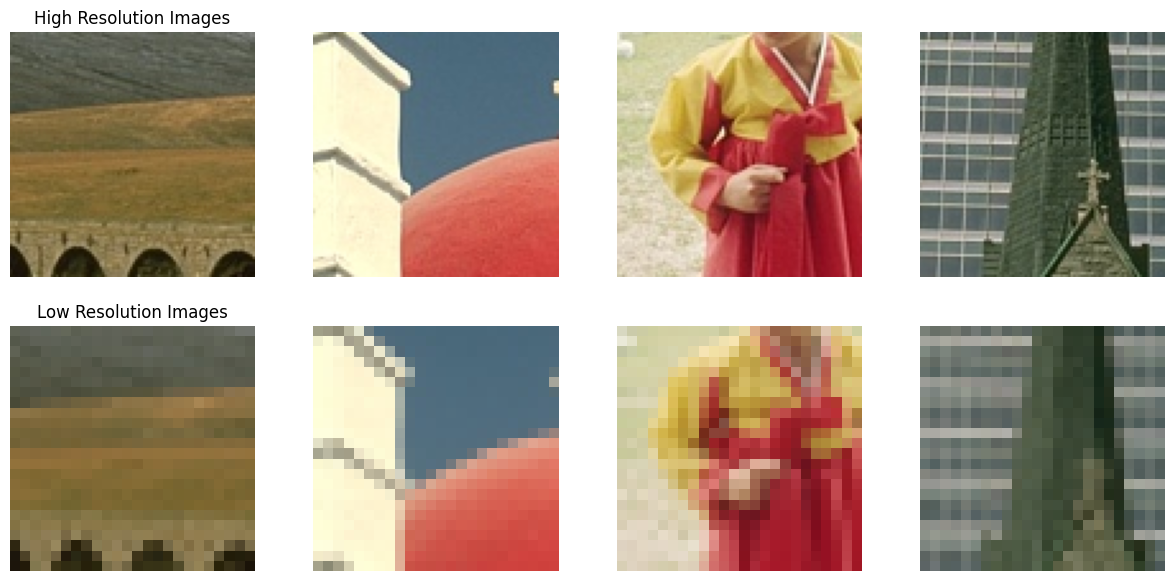

In [ ]:
#@title Load Dataset and visualize samples

data_path = "/content/BSDS500"
trainset, testset = load_data(data_path=data_path, spatial_decimation_factor=spatial_decimation_factor, batch_size=BATCH_SIZE)


num_imgs = 4
plt.figure(figsize=(15, 7))

sample = next(iter(trainset))

for i in range(num_imgs):

  x, y = sample
  x = x[i]
  y = y[i]

  plt.subplot(2, num_imgs, i + 1)
  plt.imshow(x.permute(1, 2, 0).numpy())
  plt.axis('off')

  if i == 0:
    plt.title("High Resolution Images")

  # plot the low resolution image
  plt.subplot(2, num_imgs,  num_imgs + i + 1)
  plt.imshow(y.permute(1, 2, 0).numpy())
  plt.axis('off')
  if i == 0:
    plt.title("Low Resolution Images")

plt.show()

In [ ]:
#@title Training process
psnr_fn = PeakSignalNoiseRatio(data_range=1.0, reduction='elementwise_mean').to(device)
ssim_fn = StructuralSimilarityIndexMeasure(data_range=1.0, reduction='elementwise_mean').to(device)


model.to(device)

for epoch in range(EPOCHS):

    losses, psnr, ssim = AverageMeter(), AverageMeter(), AverageMeter()
    val_losses, val_psnr, val_ssim = AverageMeter(), AverageMeter(), AverageMeter()

    model.train()
    for x, y in trainset:

        x, y = x.to(device), y.to(device)

        optimizer.zero_grad()
        x_hat = model(y)
        loss = criterion(x_hat, x)
        loss.backward()
        optimizer.step()

        psnr_val = psnr_fn(x_hat, x)
        ssim_val = ssim_fn(x_hat, x)

        losses.update(loss.item(), x.size(0))
        psnr.update(psnr_val.item(), x.size(0))
        ssim.update(ssim_val.item(), x.size(0))

    model.eval()

    for x, y in testset:

        x, y = x.to(device), y.to(device)
        x_hat = model(y)

        loss = criterion(x_hat, x)
        psnr_val = psnr_fn(x_hat, x)
        ssim_val = ssim_fn(x_hat, x)

        val_losses.update(loss.item(), x.size(0))
        val_psnr.update(psnr_val.item(), x.size(0))
        val_ssim.update(ssim_val.item(), x.size(0))

    print(f"Epoch: {epoch}, Loss: {losses.avg:.7f}, PSNR: {psnr.avg:.2f}, SSIM: {ssim.avg:.3f}, Val Loss: {val_losses.avg:.7f}, Val PSNR: {val_psnr.avg:.2f}, Val SSIM: {val_ssim.avg:.3f}")

Epoch: 0, Loss: 0.1186534, PSNR: 10.62, SSIM: 0.261, Val Loss: 0.0426661, Val PSNR: 14.23, Val SSIM: 0.415
Epoch: 1, Loss: 0.0353555, PSNR: 14.65, SSIM: 0.413, Val Loss: 0.0305824, Val PSNR: 15.61, Val SSIM: 0.439
Epoch: 2, Loss: 0.0303322, PSNR: 15.28, SSIM: 0.432, Val Loss: 0.0261963, Val PSNR: 16.26, Val SSIM: 0.457
Epoch: 3, Loss: 0.0266607, PSNR: 15.89, SSIM: 0.450, Val Loss: 0.0231195, Val PSNR: 16.78, Val SSIM: 0.473
Epoch: 4, Loss: 0.0236968, PSNR: 16.40, SSIM: 0.465, Val Loss: 0.0195752, Val PSNR: 17.49, Val SSIM: 0.489
Epoch: 5, Loss: 0.0210498, PSNR: 16.91, SSIM: 0.478, Val Loss: 0.0174041, Val PSNR: 18.01, Val SSIM: 0.501
Epoch: 6, Loss: 0.0189284, PSNR: 17.32, SSIM: 0.490, Val Loss: 0.0151170, Val PSNR: 18.61, Val SSIM: 0.513
Epoch: 7, Loss: 0.0171239, PSNR: 17.78, SSIM: 0.501, Val Loss: 0.0135689, Val PSNR: 19.09, Val SSIM: 0.523
Epoch: 8, Loss: 0.0155365, PSNR: 18.25, SSIM: 0.510, Val Loss: 0.0121119, Val PSNR: 19.58, Val SSIM: 0.532
Epoch: 9, Loss: 0.0141917, PSNR: 18.6

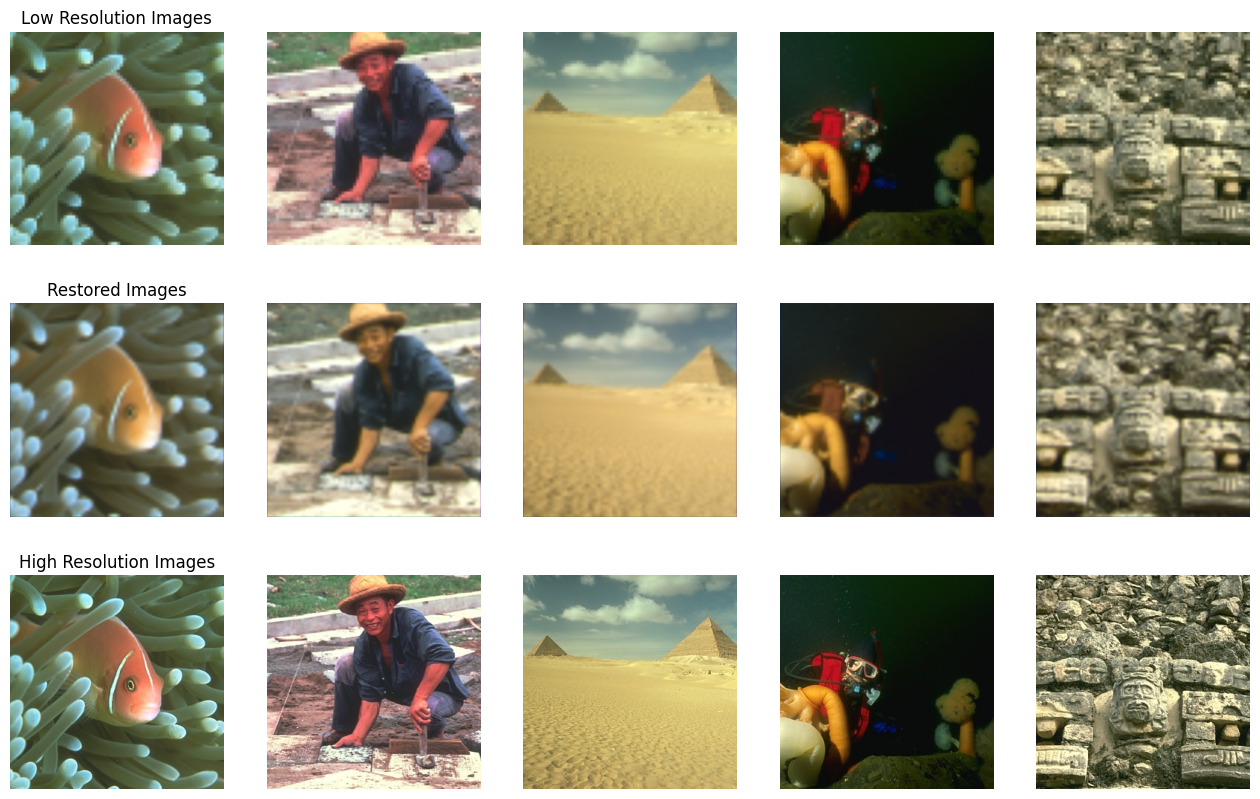

In [ ]:
#@title Inference process

num_images = 4
iter_testset = iter(testset)


fig, axs = plt.subplots(3, num_images + 1, figsize=(16, 10))

for i in range(num_images):

  x, y = next(iter_testset)
  y = y.to(device)
  x_hat = model(y).detach().cpu()
  y = y.detach().cpu()

  axs[0][i].imshow(y[0].permute(1, 2, 0).numpy())
  axs[0][i].axis('off')

  axs[1][i].imshow(x_hat[0].permute(1, 2, 0).numpy())
  axs[1][i].axis('off')

  axs[2][i].imshow(x[0].permute(1, 2, 0).numpy())
  axs[2][i].axis('off')

  if i == 0:
      axs[0][i].set_title("Low Resolution Images")
      axs[1][i].set_title("Restored Images")
      axs[2][i].set_title("High Resolution Images")

iter_n = np.random.randint(num_images, len(testset)-num_images)
for _ in range(iter_n):
  	x, y = next(iter_testset)

y = y.to(device)
x_hat = model(y).detach().cpu()
y = y.detach().cpu()

axs[0][-1].imshow(y[0].permute(1, 2, 0).numpy())
axs[0][-1].axis('off')

axs[1][-1].imshow(x_hat[0].permute(1, 2, 0).numpy())
axs[1][-1].axis('off')


axs[2][-1].imshow(x[0].permute(1, 2, 0).numpy())
axs[2][-1].axis('off')

plt.show()